In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
base_path = 'Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

data = []

for category in categories:
    category_path = os.path.join(base_path, category)
    
    for filename in os.listdir(category_path):
        if filename.endswith('.png') and '_mask' not in filename:  # Exclude mask images
            file_path = os.path.join(category_path, filename)
            data.append({'image_path': file_path, 'label': category})

df = pd.DataFrame(data)

In [4]:
df.head()

,image_path,label
0,Dataset_BUSI_with_GT\benign\benign (1).png,benign
1,Dataset_BUSI_with_GT\benign\benign (10).png,benign
2,Dataset_BUSI_with_GT\benign\benign (100).png,benign
3,Dataset_BUSI_with_GT\benign\benign (101).png,benign
4,Dataset_BUSI_with_GT\benign\benign (102).png,benign


In [5]:
df.tail()

,image_path,label
775,Dataset_BUSI_with_GT\normal\normal (95).png,normal
776,Dataset_BUSI_with_GT\normal\normal (96).png,normal
777,Dataset_BUSI_with_GT\normal\normal (97).png,normal
778,Dataset_BUSI_with_GT\normal\normal (98).png,normal
779,Dataset_BUSI_with_GT\normal\normal (99).png,normal


In [6]:
df.shape

(780, 2)

In [7]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  780 non-null    object
 1   label       780 non-null    object
dtypes: object(2)
memory usage: 12.3+ KB


C:\Users\HP\AppData\Local\Temp\ipykernel_1536\2018193438.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='label', palette='viridis')


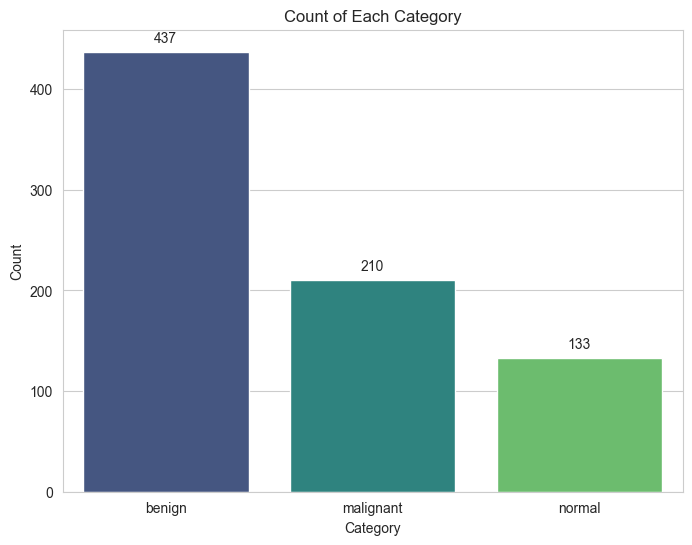

In [9]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x='label', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

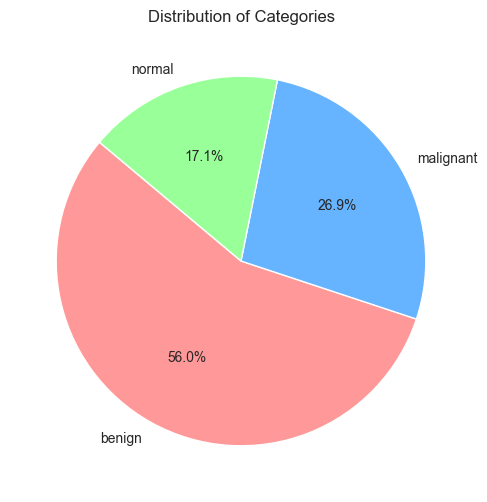

In [10]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

plt.title("Distribution of Categories")

plt.show()

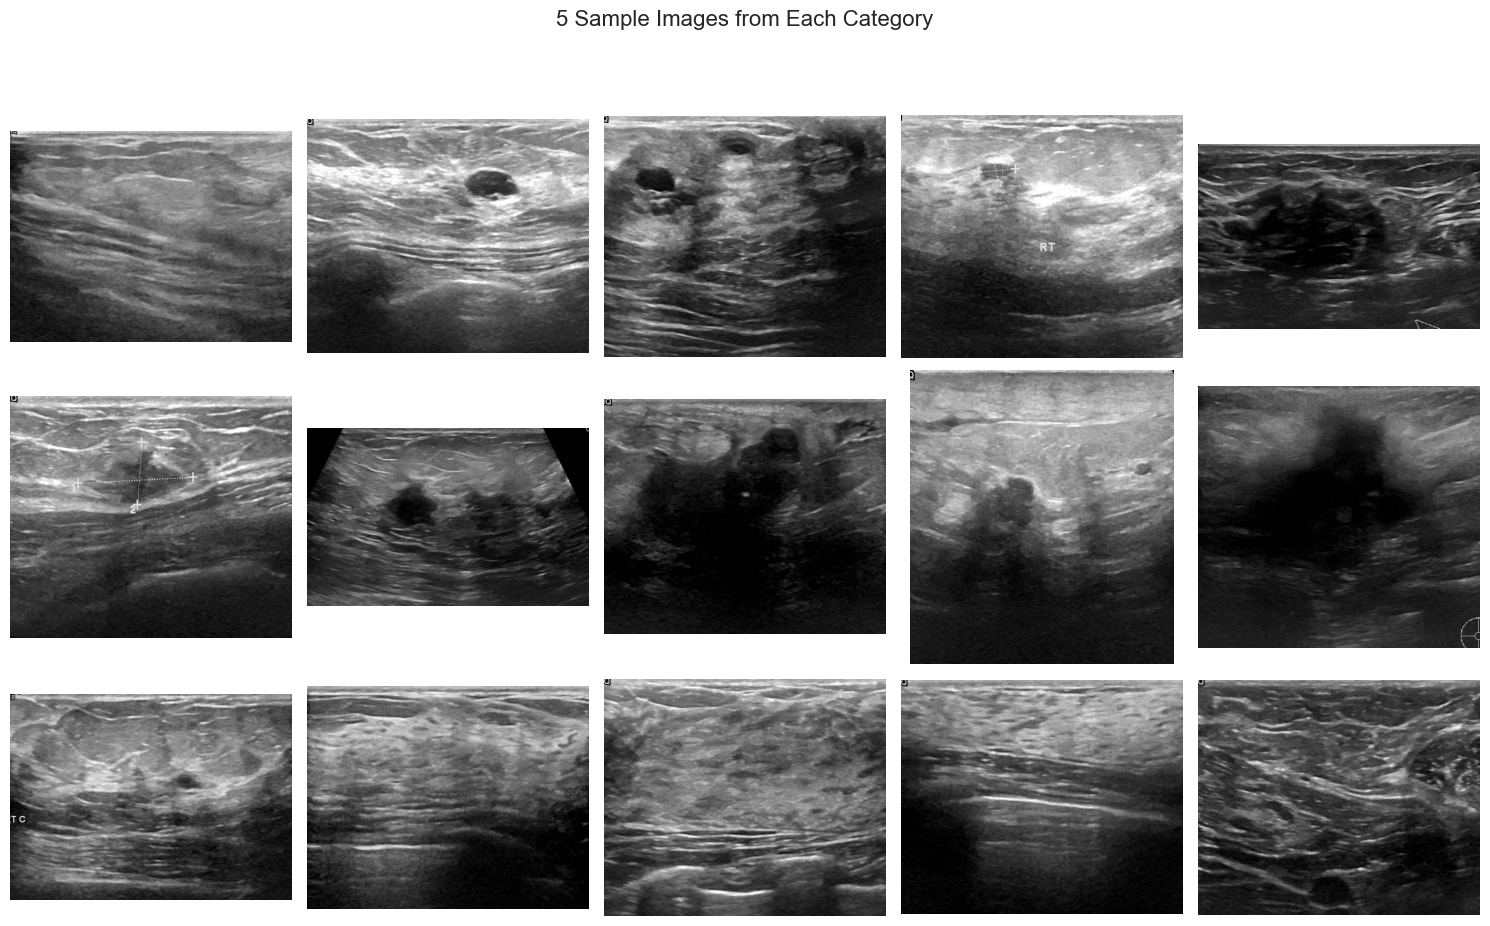

In [11]:
num_images = 5

fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(categories):
    
    sample_images = df[df['label'] == category].sample(num_images, random_state=42)
    
    for j, image_path in enumerate(sample_images['image_path']):
    
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  
        if j == 0:
            axes[i, j].set_ylabel(category, fontsize=14)  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

In [12]:
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [13]:
df = df[['image_path', 'category_encoded']]

In [14]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

In [15]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [16]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    437
1    437
2    437
Name: count, dtype: int64


In [17]:
df_resampled

,image_path,category_encoded
0,Dataset_BUSI_with_GT\benign\benign (1).png,0
1,Dataset_BUSI_with_GT\benign\benign (10).png,0
2,Dataset_BUSI_with_GT\benign\benign (100).png,0
3,Dataset_BUSI_with_GT\benign\benign (101).png,0
4,Dataset_BUSI_with_GT\benign\benign (102).png,0
...,...,...
1306,Dataset_BUSI_with_GT\normal\normal (76).png,2
1307,Dataset_BUSI_with_GT\normal\normal (60).png,2
1308,Dataset_BUSI_with_GT\normal\normal (6).png,2
1309,Dataset_BUSI_with_GT\normal\normal (115).png,2


In [18]:
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [19]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [20]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)

In [21]:
batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='category_encoded',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 1048 validated image filenames belonging to 3 classes.
Found 131 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
def create_vgg16_modified_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = VGG16(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    x = base_model.output
    
    attention_output = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_modified_model = create_vgg16_modified_model(input_shape)

cnn_modified_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

In [25]:
history = cnn_modified_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5599 - loss: 0.9769 - val_accuracy: 0.3282 - val_loss: 1.5754
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7931 - loss: 0.4985 - val_accuracy: 0.6565 - val_loss: 0.7914
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9120 - loss: 0.2525 - val_accuracy: 0.8321 - val_loss: 0.4129
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9162 - loss: 0.2210 - val_accuracy: 0.8473 - val_loss: 0.3358
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9588 - loss: 0.1468 - val_accuracy: 0.8550 - val_loss: 0.5504


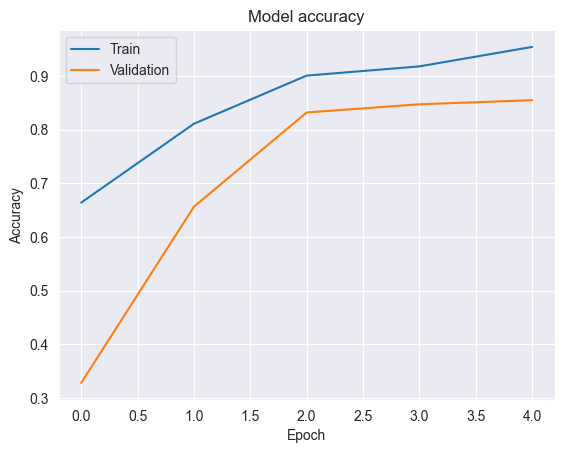

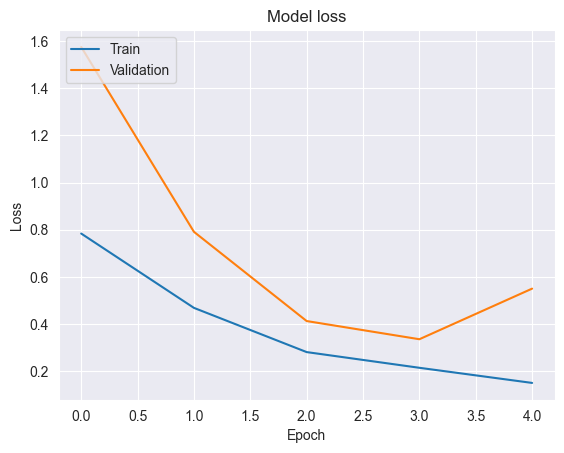

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
test_labels = test_gen_new.classes  
predictions = cnn_modified_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [28]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print("Report for VGG16=>")
print(report)

Report for VGG16=>
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        44
           1       0.95      0.91      0.93        44
           2       0.92      1.00      0.96        44

    accuracy                           0.93       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



In [29]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

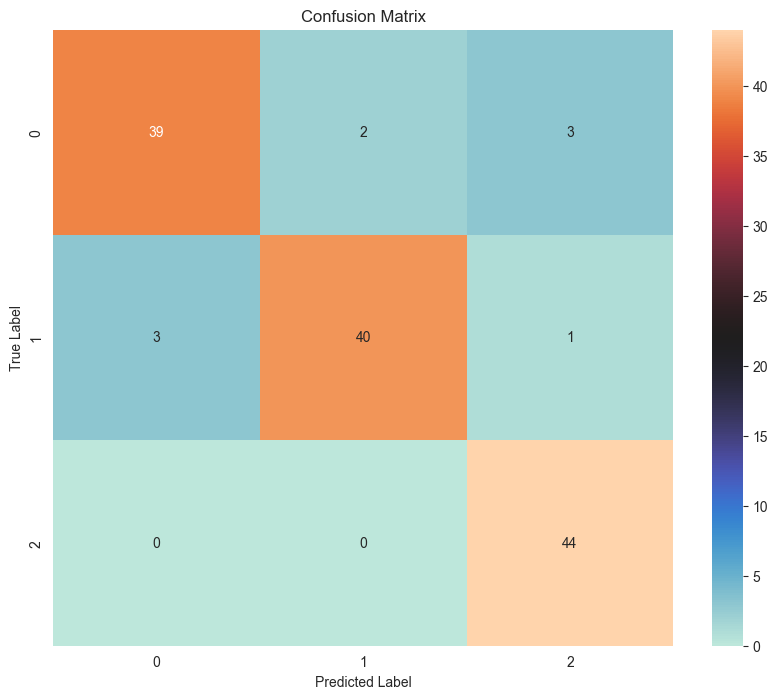

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
def create_xception_modified_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    x = base_model.output
    
    attention_output = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_modified_model_xception = create_xception_modified_model(input_shape)

cnn_modified_model_xception.compile(optimizer=Adam(learning_rate=0.0001),
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy'])


In [32]:
history = cnn_modified_model_xception.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.6295 - loss: 0.8896 - val_accuracy: 0.6260 - val_loss: 0.7639
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.8349 - loss: 0.4151 - val_accuracy: 0.9084 - val_loss: 0.4195
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 6470s 99s/step - accuracy: 0.9223 - loss: 0.2256 - val_accuracy: 0.9008 - val_loss: 0.2760
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.9477 - loss: 0.1479 - val_accuracy: 0.9084 - val_loss: 0.2561
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.9709 - loss: 0.1180 - val_accuracy: 0.9618 - val_loss: 0.1587


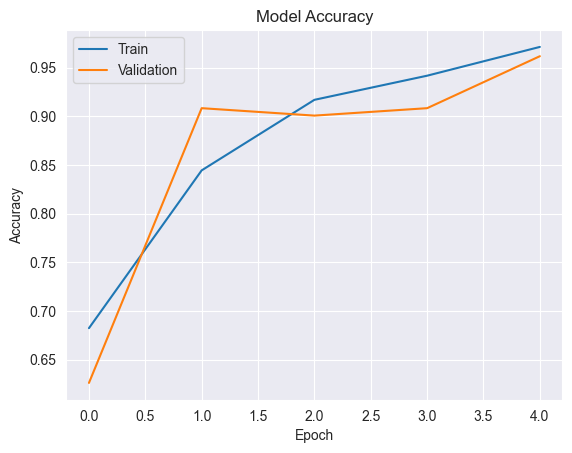

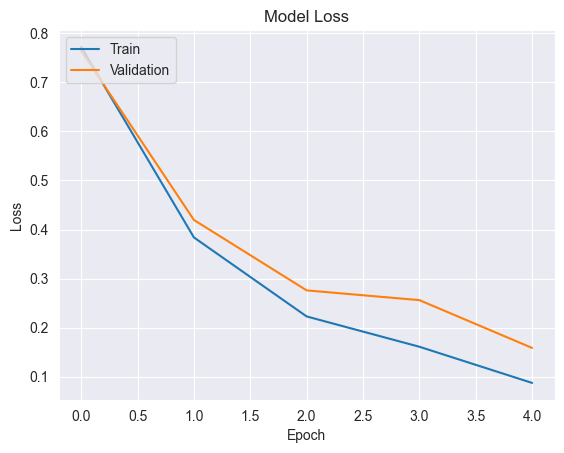

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
test_labels = test_gen_new.classes  
predictions = cnn_modified_model_xception.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [35]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print("Report for Xception =>")
print(report)

Report for Xception =>
              precision    recall  f1-score   support

           0       0.97      0.86      0.92        44
           1       0.95      0.95      0.95        44
           2       0.90      1.00      0.95        44

    accuracy                           0.94       132
   macro avg       0.94      0.94      0.94       132
weighted avg       0.94      0.94      0.94       132



In [36]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

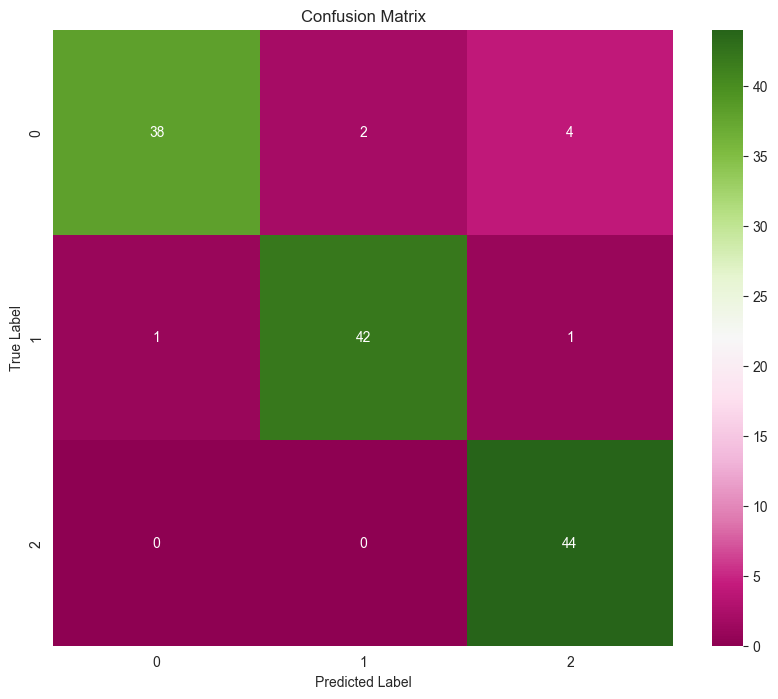

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PiYG', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

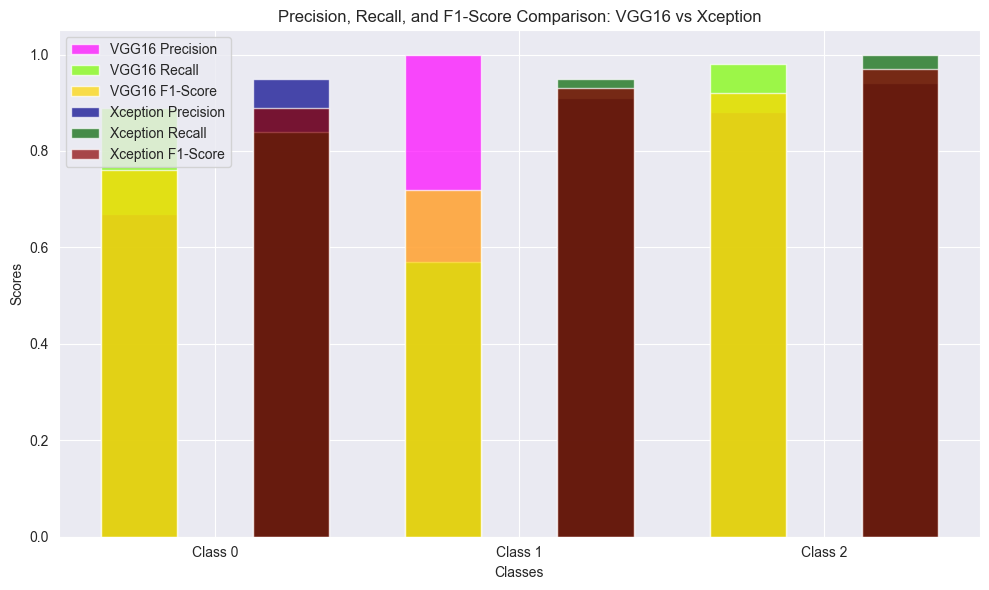

In [38]:
classes = ['Class 0', 'Class 1', 'Class 2']
vgg16_precision = [0.67, 1.00, 0.88]
vgg16_recall = [0.89, 0.57, 0.98]
vgg16_f1_score = [0.76, 0.72, 0.92]

xception_precision = [0.95, 0.91, 0.94]
xception_recall = [0.84, 0.95, 1.00]
xception_f1_score = [0.89, 0.93, 0.97]

x = np.arange(len(classes)) 
width = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, vgg16_precision, width, label='VGG16 Precision', color='magenta', alpha=0.7)
ax.bar(x - width, vgg16_recall, width, label='VGG16 Recall', color='lawngreen', alpha=0.7)
ax.bar(x - width, vgg16_f1_score, width, label='VGG16 F1-Score', color='gold', alpha=0.7)

ax.bar(x + width, xception_precision, width, label='Xception Precision', color='darkblue', alpha=0.7)
ax.bar(x + width, xception_recall, width, label='Xception Recall', color='darkgreen', alpha=0.7)
ax.bar(x + width, xception_f1_score, width, label='Xception F1-Score', color='darkred', alpha=0.7)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score Comparison: VGG16 vs Xception')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()